In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
def evaluate_policy(P, R, policy, test_count=100, gamma=0.9):
    num_state = P.shape[-1]
    total_episode = num_state * test_count
    # start in each state
    total_reward = 0
    for state in range(num_state):
        state_reward = 0
        for _ in range(test_count):
            episode_reward = 0
            disc_rate = 1
            while True:
                # take step
                action = policy[state]
                # get next step using P
                probs = P[action][state]
                candidates = list(range(len(P[action][state])))
                next_state =  np.random.choice(candidates, 1, p=probs)[0]
                # get the reward
                reward = R[state][action] * disc_rate
                episode_reward += reward
                # when go back to 0 ended
                disc_rate *= gamma
                if next_state == 0:
                    break
            state_reward += episode_reward
        total_reward += state_reward
    return total_reward / total_episode

def trainQLearning(P, R, test_count, discount=0.9, alpha_dec=[0.99], alpha_min=[0.001], 
            epsilon=[1.0], epsilon_decay=[0.99], n_iter=[1000000]):
    from hiive.mdptoolbox.mdp import QLearning
    q_df = pd.DataFrame(columns=["Iterations", "Alpha Decay", "Alpha Min", 
                                 "Epsilon", "Epsilon Decay", "Reward",
                                 "Time", "Policy", "Value Function",
                                 "Training Rewards"])
    
    count = 0
    for i in n_iter:
        for eps in epsilon:
            for eps_dec in epsilon_decay:
                for a_dec in alpha_dec:
                    for a_min in alpha_min:
                        q = QLearning(P, R, discount, alpha_decay=a_dec, 
                                      alpha_min=a_min, epsilon=eps, 
                                      epsilon_decay=eps_dec, n_iter=i)
                        q.run()
                        reward = evaluate_policy(P, R, q.policy, test_count)
                        count += 1
                        print("{}: {}".format(count, reward))
                        st = q.run_stats
                        rews = [s['Reward'] for s in st]
                        info = [i, a_dec, a_min, eps, eps_dec, reward, 
                                q.time, q.policy, q.V, rews]
                        df_length = len(q_df)
                        q_df.loc[df_length] = info
    return q_df

In [41]:
from hiive.mdptoolbox import example
def run_Forest_q(states, test_count):
    # New way
    print('Q LEARNING WITH FOREST MANAGEMENT ' + str(states) + ' STATES ')
    P, R = example.forest(S=states,p=0.01)
    eps = [0.25,0.5,0.75,0.95]
    iters = [10000, 100000, 1000000]
    q_df = trainQLearning(P, R, test_count, discount=0.9, epsilon=eps, n_iter=iters)
    
    # f, ax = plt.subplots(1,2, figsize=(8,4))
    # ax[0].set_title("Reward", fontsize=16)
    # for frame in [q_df[(q_df.Epsilon == ep)] for ep in eps]:
    #     plt.plot(frame['Iterations'], frame['Reward'], alpha=1, label="Gamma: {}".format(frame['Epsilon']))
    # ax[0].legend()
    # ax[0].set_xlabel("# Iterations")
    
    # ax[1].set_title("Reward", fontsize=16)
    # for frame in [q_df[(q_df.Epsilon == ep)] for ep in eps]:
    #     plt.plot(frame['Iterations'], frame['Time'], alpha=1, label="Gamma: {}".format(frame['Epsilon']))
    # ax[1].legend()
    # ax[1].set_xlabel("# Iterations")
    # plt.show()

    return q_df

In [ ]:
q_df = run_Forest_q(500, 1000)
eps = [0.25,0.5,0.75,0.95]

Text(0.5, 1.0, 'Reward')

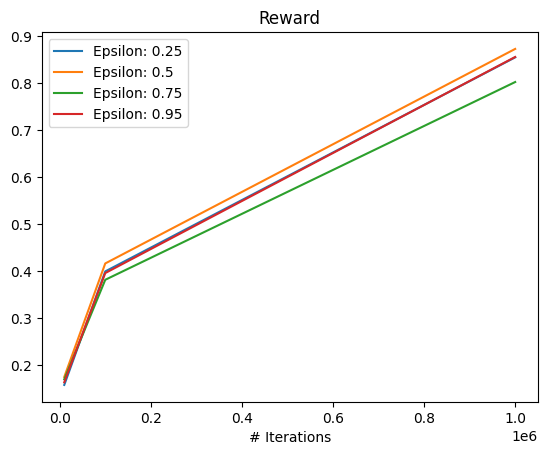

In [76]:
i = 0
for frame in [q_df[(q_df.Epsilon == ep)] for ep in eps]:
    plt.plot(frame["Iterations"], frame["Reward"], alpha=1, label=f"Epsilon: {eps[i]}")
    i+=1
plt.legend()
plt.xlabel("# Iterations")
plt.title("Reward")

Text(0.5, 1.0, 'Time')

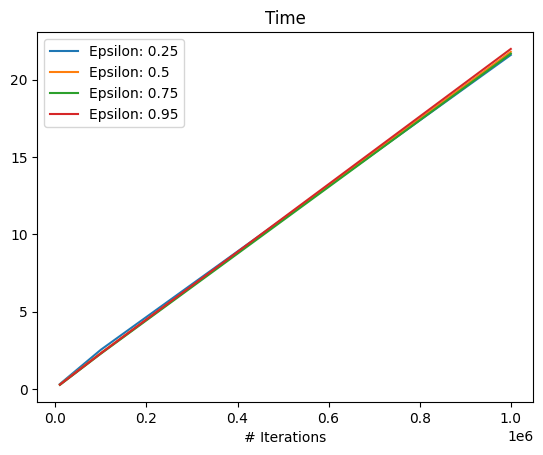

In [77]:
i = 0
for frame in [q_df[(q_df.Epsilon == ep)] for ep in eps]:
    plt.plot(frame["Iterations"], frame["Time"], alpha=1, label=f"Epsilon: {eps[i]}")
    i+=1
plt.legend()
plt.xlabel("# Iterations")
plt.title("Time")

In [30]:
from hiive.mdptoolbox import example, mdp
def run_Forest(states, test_count):

    print('POLICY ITERATION WITH FOREST MANAGEMENT ' + str(states) + ' STATES')
    max_vs = []
    mean_vs = []
    errors = []
    rewards = []
    iterations = []
    times = []
    
    P, R = example.forest(S=states)

    gammas = [0] * 10
    for i in range(0,10):
        pi = mdp.PolicyIteration(P, R, (i+0.5)/10)
        pi.run()

        iterations.append(list(range(1,len(pi.run_stats)+1)))
        max_vs.append([el['Max V'] for el in pi.run_stats])
        mean_vs.append([el['Mean V'] for el in pi.run_stats])
        errors.append([el['Error'] for el in pi.run_stats])
        rewards.append([el['Reward'] for el in pi.run_stats])
        times.append([el['Time'] for el in pi.run_stats])
        
        gammas[i]=(i+0.5)/10

    f, ax = plt.subplots(1,4, figsize=(16,4))
    ax[0].set_title("Max V", fontsize=16)
    for i in range(len(max_vs)):
        ax[0].plot(iterations[i], max_vs[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[0].legend()
    ax[0].set_xlabel("# Iterations")

    ax[1].set_title("Mean V", fontsize=16)
    for i in range(len(mean_vs)):
        ax[1].plot(iterations[i], mean_vs[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[1].legend()
    ax[1].set_xlabel("# Iterations")

    ax[2].set_title("Error", fontsize=16)
    for i in range(len(errors)):
        ax[2].plot(iterations[i], errors[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[2].legend()
    ax[2].set_xlabel("# Iterations")
    
    ax[3].set_title("Time", fontsize=16)
    for i in range(len(errors)):
        ax[3].plot(iterations[i], times[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[3].legend()
    ax[3].set_xlabel("# Iterations")
    
    P, R = example.forest(S=states)
    
    max_vs = []
    mean_vs = []
    errors = []
    rewards = []
    iterations = []
    times = []

    iters = [0]*10
    gammas = [0] * 10
    for i in range(0,10):
        pi = mdp.ValueIteration(P, R, (i+0.5)/10)
        pi.run()
        gammas[i]=(i+0.5)/10
        iterations.append(list(range(1,len(pi.run_stats)+1)))
        max_vs.append([el['Max V'] for el in pi.run_stats])
        mean_vs.append([el['Mean V'] for el in pi.run_stats])
        errors.append([el['Error'] for el in pi.run_stats])
        rewards.append([el['Reward'] for el in pi.run_stats])
        times.append([el['Time'] for el in pi.run_stats])
        
    f, ax = plt.subplots(1,4, figsize=(16,4))
    ax[0].set_title("Max V", fontsize=16)
    for i in range(len(max_vs)):
        ax[0].plot(iterations[i], max_vs[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[0].legend()
    ax[0].set_xlabel("# Iterations")

    ax[1].set_title("Mean V", fontsize=16)
    for i in range(len(mean_vs)):
        ax[1].plot(iterations[i], mean_vs[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[1].legend()
    ax[1].set_xlabel("# Iterations")

    ax[2].set_title("Error", fontsize=16)
    for i in range(len(errors)):
        ax[2].plot(iterations[i], errors[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[2].legend()
    ax[2].set_xlabel("# Iterations")
    
    ax[3].set_title("Time", fontsize=16)
    for i in range(len(errors)):
        ax[3].plot(iterations[i], times[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[3].legend()
    ax[3].set_xlabel("# Iterations")

STARTING FOREST MANAGEMENT 20 STATES
POLICY ITERATION WITH FOREST MANAGEMENT 500 STATES


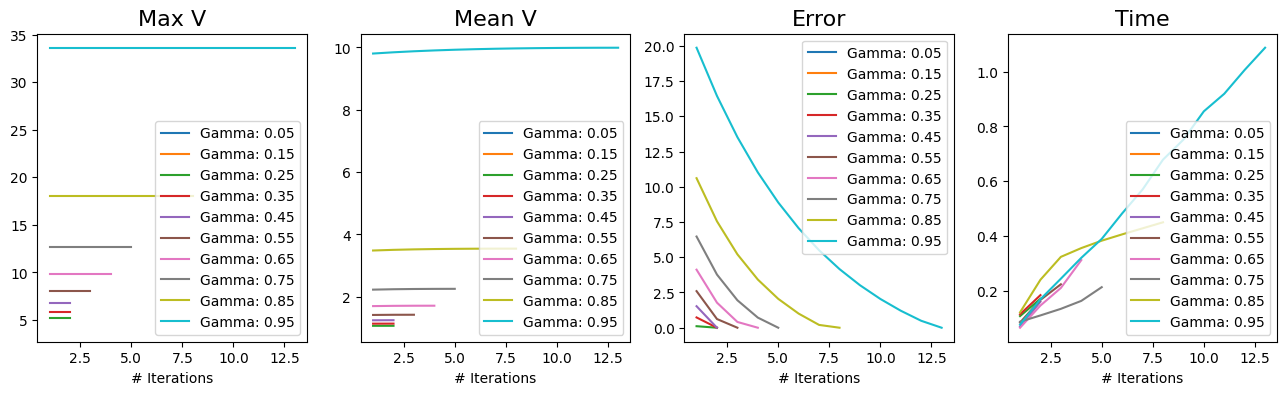

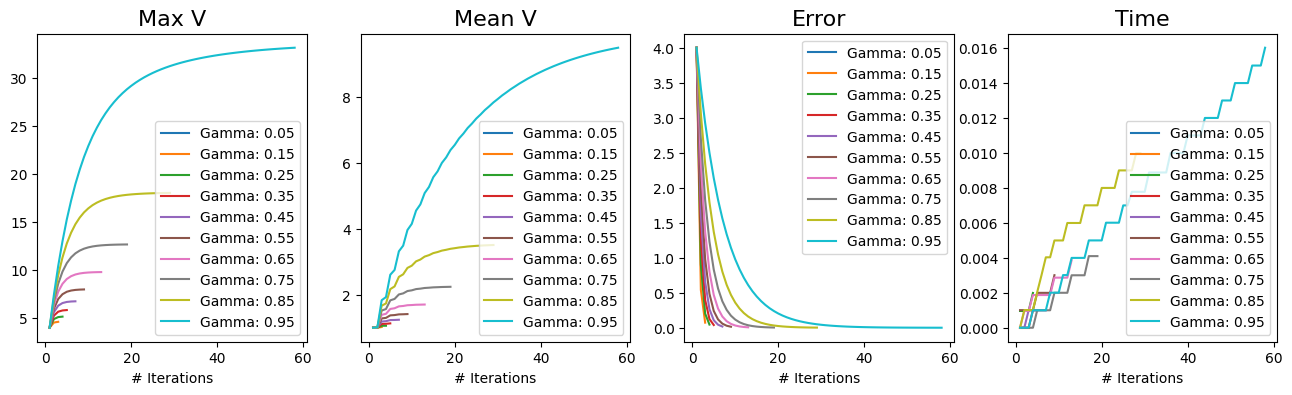

In [32]:
print('STARTING FOREST MANAGEMENT 20 STATES')
run_Forest(500, 1000) # States, test_count

In [88]:
P, R = example.forest(S=500)
pi = mdp.PolicyIteration(P, R, 0.95)
pi.run()
optimal_policy_PI = pi.policy

In [87]:
P, R = example.forest(S=500)
pi = mdp.PolicyIteration(P, R, 0.95)
pi.run()
optimal_policy_VI = pi.policy

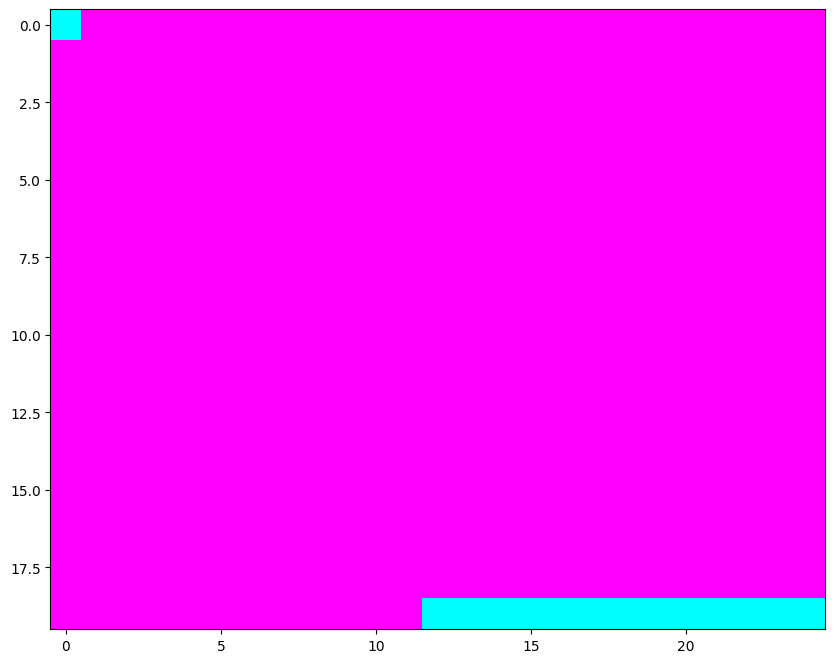

In [97]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
im = ax.imshow(np.array(optimal_policy_PI).reshape(20, 25), cmap='cool')

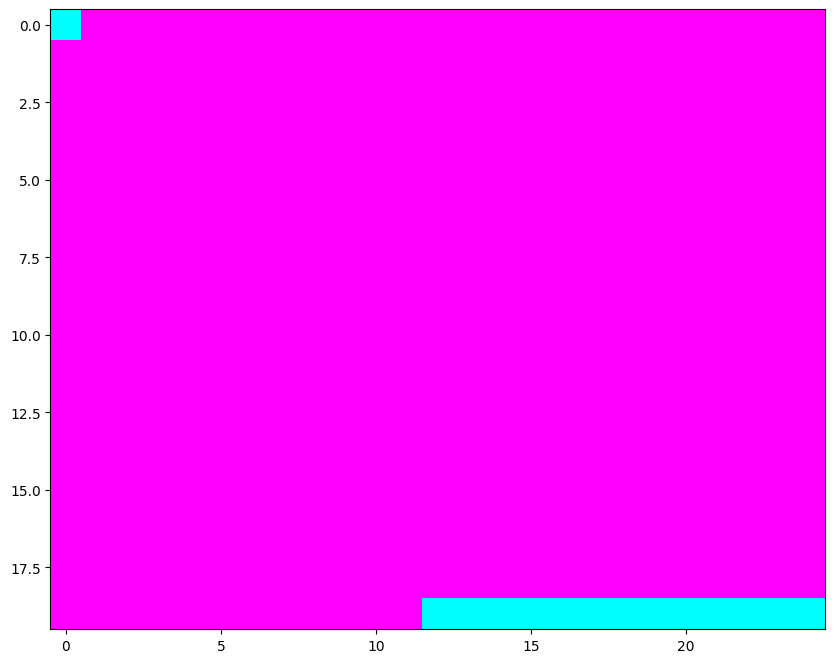

In [98]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
im = ax.imshow(np.array(optimal_policy_VI).reshape(20, 25), cmap='cool')